# Getting Started

## General Tips
In each homework problem, you will implement various autoencoder models and run them on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [1]:
# get to the parent dir of mai_dul repo
import os

# os.chdir('../../')
os.getcwd()

'/home/ordem/PycharmProjects/MAI_DUL_WS24/homeworks/hw2'

In [2]:
# install latest version deepul package
# !pip install -e .

In [3]:
from deepul.hw2_helper import *

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


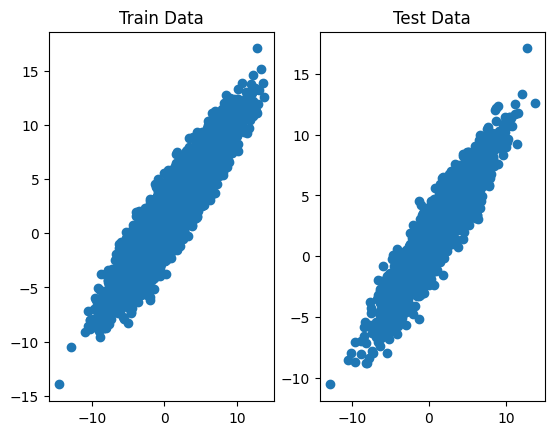

Dataset 2


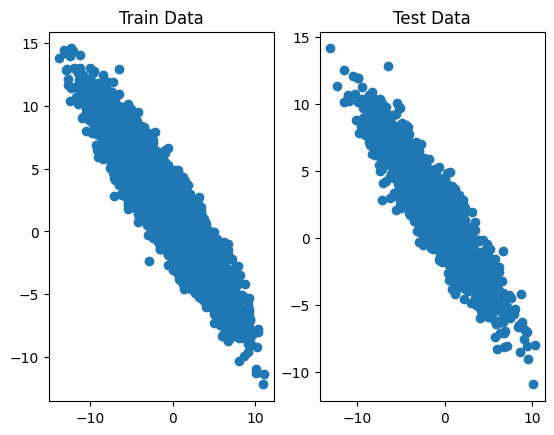

In [4]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [5]:
from torch.nn.functional import mse_loss
from torch.optim import Adam
from models.vae import VAEModel
from torch.utils.data import TensorDataset


def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    n_features = train_data.shape[1]
    latent_size = 2
    learning_rate = 0.001
    batch_size = 128
    max_epochs = 10
    beta = 0.5

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_dataset = TensorDataset(torch.tensor(train_data))
    x_test = torch.tensor(test_data).to(device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = VAEModel(input_size=n_features, latent_size=latent_size,hidden_units=16, regularization_weight=beta).to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []
    
    with torch.no_grad():
        test_logits= model.forward(x_test)
        loss, recon_loss, kl_reg = model.loss_function(x_test,test_logits)
        test_losses.append(np.array([ loss.item(), recon_loss.item(), kl_reg.item()]))

    for epoch in range(max_epochs):
        batches = iter(train_loader)
        for i, [batch] in enumerate(batches):
            batch_x = batch.to(device)
            batch_logits = model.forward(batch_x)
            loss, recon_loss, kl_reg = model.loss_function(batch_x, batch_logits)
            loss.backward()
            train_losses.append(np.array([ loss.item(), recon_loss.item(), kl_reg.item()]))
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            test_logits= model.forward(x_test)
            loss, recon_loss, kl_reg = model.loss_function(x_test,test_logits)
            test_losses.append(np.array([ loss.item(), recon_loss.item(), kl_reg.item()]))
        model.train()
    train_losses = np.array(train_losses)
    test_losses = np.array(test_losses)
    samples_noise = model.generate(1000, with_noise=True).numpy(force=True)
    samples_no_noise = model.generate(1000, with_noise=False).numpy(force=True)
    return train_losses, test_losses, samples_noise, samples_no_noise



### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

Final -ELBO: 1.4134, Recon Loss: 1.1851, KL Loss: 1.6418


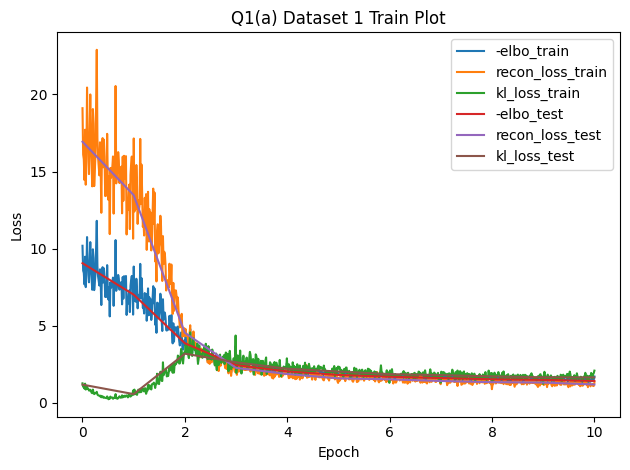

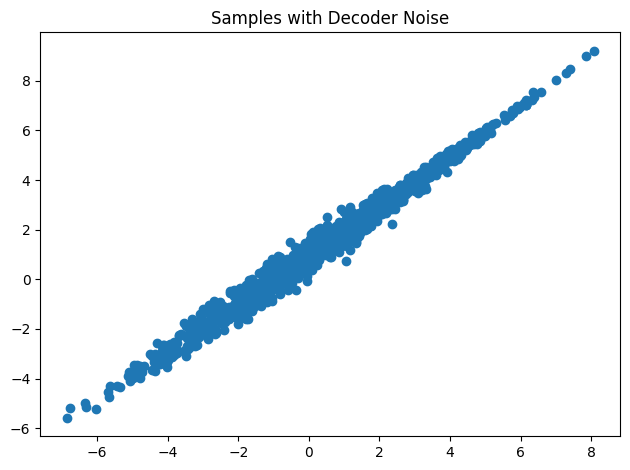

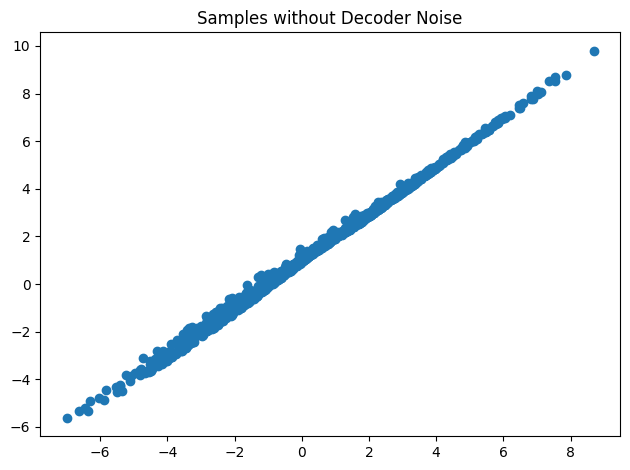

In [6]:
q1_save_results('a', 1, q1)

Final -ELBO: 1.6280, Recon Loss: 1.4461, KL Loss: 1.8099


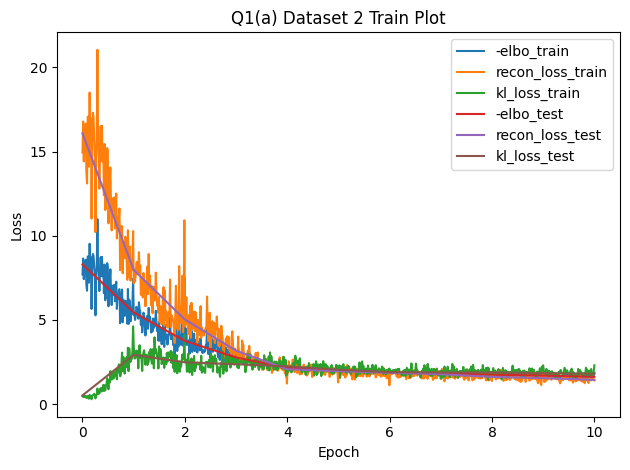

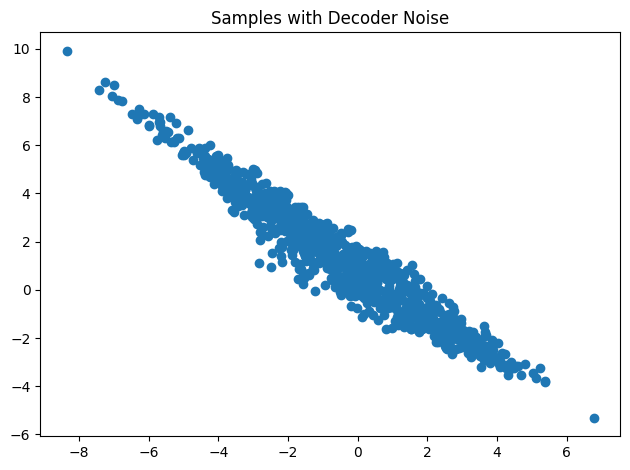

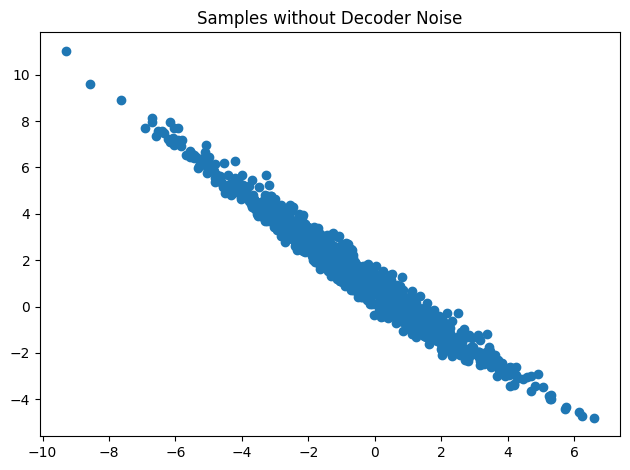

In [7]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


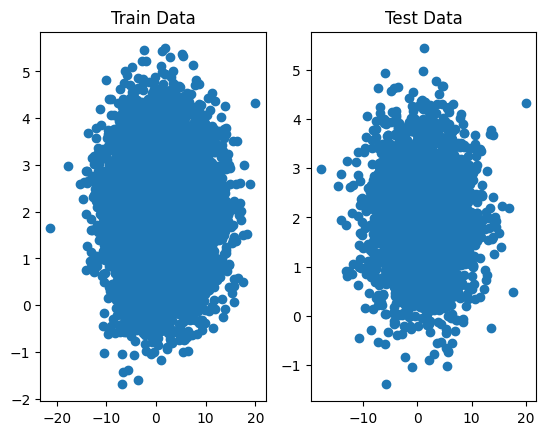

Dataset 2


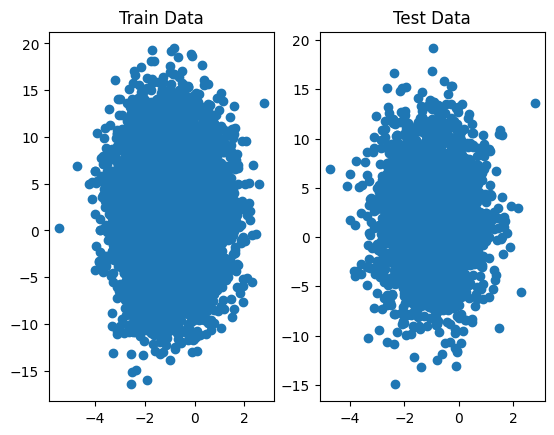

In [8]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

Final -ELBO: 1.4760, Recon Loss: 1.2935, KL Loss: 1.6585


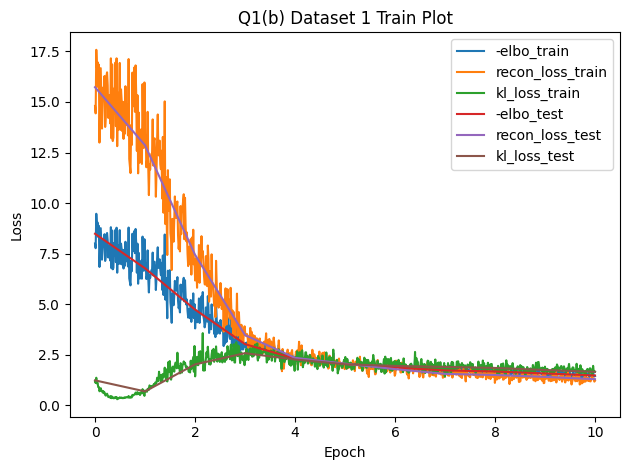

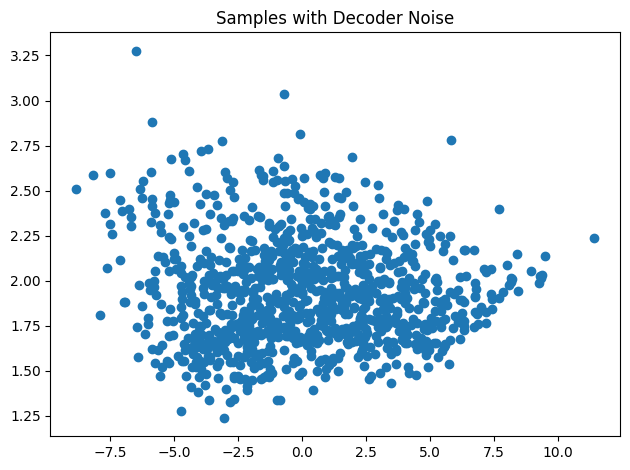

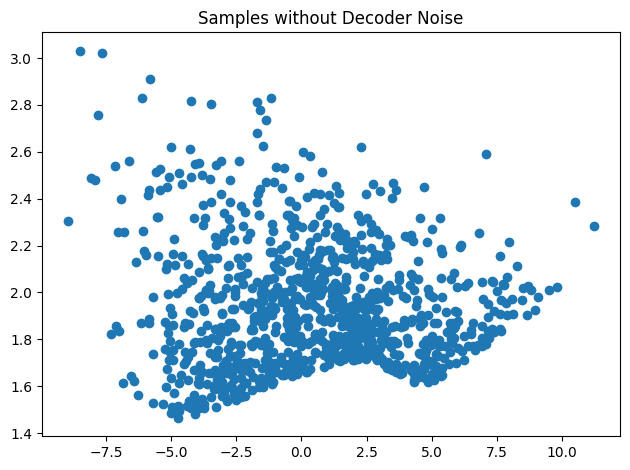

In [9]:
q1_save_results('b', 1, q1)

Final -ELBO: 1.5183, Recon Loss: 1.2906, KL Loss: 1.7461


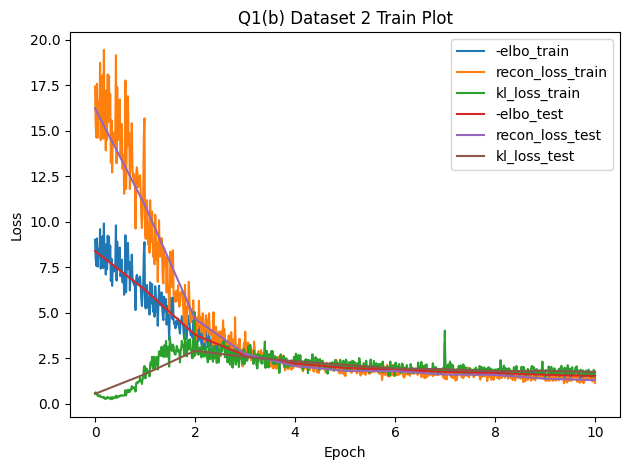

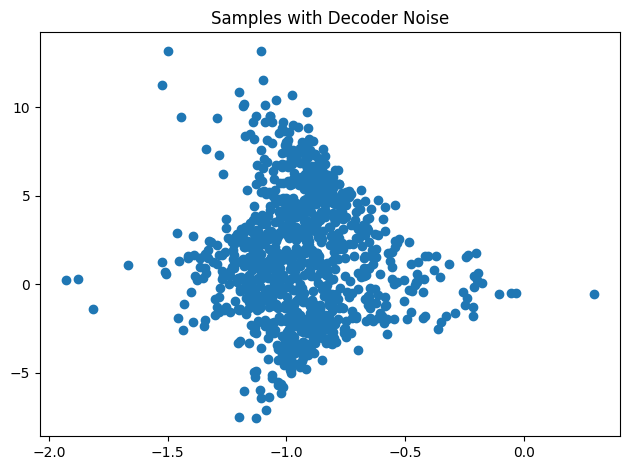

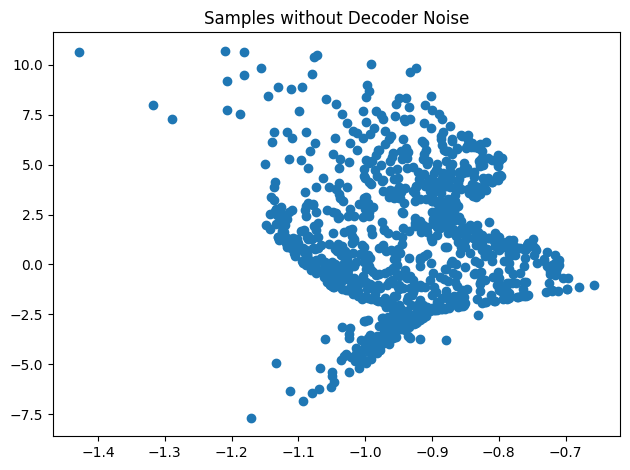

In [10]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without latents in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**